<a href="https://colab.research.google.com/github/dddonghwa/dacon-struggle/blob/main/housing_0127_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import os.path as osp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [ ]:
data_dir = './drive/MyDrive/Colab Notebooks/DACrew/housing/dataset'

train = pd.read_csv(osp.join(data_dir, 'train.csv'))
test = pd.read_csv(osp.join(data_dir, 'test.csv'))

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
print( train.shape, test.shape)

train.head()

(1350, 14) (1350, 13)


,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


In [ ]:
# 중복값 제거
print("제거 전 :", train.shape)
train = train.drop_duplicates()
print("제거 후 :", train.shape)

제거 전 : (1350, 14)
제거 후 : (1349, 14)


In [ ]:
# Garage Yr Blt 이상치 수정 2207 → 2007
# train[train['Garage Yr Blt']> 2050] # 254
train.loc[254, 'Garage Yr Blt'] = 2007

In [ ]:
# 품질 관련 변수 → 숫자로 매핑
qual_cols = train.dtypes[train.dtypes == np.object].index
def label_encoder(df_, qual_cols):
  df = df_.copy()
  mapping={
      'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1
  }
  for col in qual_cols :
    df[col] = df[col].map(mapping)
  return df

train = label_encoder(train, qual_cols)
test = label_encoder(test, qual_cols)
train.head()

,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,10,2392,5,3,968,5,2392,2392,5,2,2003,2003,2003,386250
1,7,1352,4,2,466,4,1352,1352,5,2,2006,2007,2006,194000
2,5,900,3,1,288,3,864,900,3,1,1967,1967,1967,123000
3,5,1174,3,2,576,4,680,680,3,1,1900,2006,2000,135000
4,7,1958,4,3,936,4,1026,1026,4,2,2005,2005,2005,250000


In [ ]:
# 변수 재배치
cols = ['Year Built','Year Remod/Add','Garage Yr Blt', # 년도
        'Overall Qual',  'Exter Qual','Kitchen Qual','Bsmt Qual', # 품질
        'Gr Liv Area','Total Bsmt SF', '1st Flr SF', 'Garage Area', # 면적
        'Garage Cars', 'Full Bath'] # 갯수
train = train[cols+['target']]
test = test[cols]

train.head()

,Year Built,Year Remod/Add,Garage Yr Blt,Overall Qual,Exter Qual,Kitchen Qual,Bsmt Qual,Gr Liv Area,Total Bsmt SF,1st Flr SF,Garage Area,Garage Cars,Full Bath,target
0,2003,2003,2003,10,5,5,5,2392,2392,2392,968,3,2,386250
1,2006,2007,2006,7,4,4,5,1352,1352,1352,466,2,2,194000
2,1967,1967,1967,5,3,3,3,900,864,900,288,1,1,123000
3,1900,2006,2000,5,3,4,3,1174,680,680,576,2,1,135000
4,2005,2005,2005,7,4,4,4,1958,1026,1026,936,3,2,250000


id : 데이터 고유 id  
#### 품질 피처
OverallQual : 전반적 재료와 마감 품질  
ExterQual : 외관 재료 품질  
KitchenQual : 부억 품질  
BsmtQual : 지하실 높이(품질) 

#### 년도 피처
YearBuilt : 완공 연도  
YearRemodAdd : 리모델링 연도  
GarageYrBlt : 차고 완공 연도  

#### 면적 피처
TotalBsmtSF : 지하실 면적   

1stFlrSF : 1층 면적   
GrLivArea : 지상층 생활 면적  
FullBath : 지상층 화장실 개수  

GarageCars: 차고 자리 개수  
GarageArea: 차고 면적   

target : 집값(달러 단위)  

## 피처 엔지니어링 변수 아이디어

면적 관련 피처 중요

- 리모델링 연도 차 `Year Gap Remod`  = 리모델링 연도 - 완공 연도
- 차고 자리당 면적 `Car Area`= 차고 면적/차고 자리 개수
- 2층 면적 `2nd flr SF`= 지상층 생활 면적 - 1층 면적
- 2층 여부 `2nd flr`= 1(지상층 생활 면적 - 1층 면적 > 0), 0(지상층 생활 면적 - 1층 면적 < 0)
- 전체 면적 `Total SF` = 지상층 생활 면적 + 지하실 면적 + 차고 면적
- 품질 합 `Sum Qual` = (전반적 + 부억 + 재료 + 지하실) 품질 
- 차고 밖/안 `Garage In/Out` = 1(지상층 생활 면적 != 1층 면적), 0(지상층 생활 면적 == 1층 면적) 

In [ ]:
area_cols = ["Gr Liv Area", "Garage Area", "Total Bsmt SF", "1st Flr SF"]
year_cols = ["Year Built", "Year Remod/Add", "Garage Yr Blt"]
qual_cols = ["Exter Qual", "Kitchen Qual", "Overall Qual"]
cnt_cols = ['Full Bath', 'Garage Cars', 'Bsmt Qual']

In [ ]:
def feature_eng(data_):
  data = data_.copy()
  data['Year Gap Remod'] = data['Year Remod/Add'] - data['Year Built']
  data['Car Area'] = data['Garage Area']/data['Garage Cars']
  data['2nd flr SF'] = data['Gr Liv Area'] - data['1st Flr SF']
  data['2nd flr'] = data['2nd flr SF'].apply(lambda x : 1 if x > 0 else 0)
  data['Total SF'] = data[['Gr Liv Area',"Garage Area", "Total Bsmt SF"]].sum(axis=1)
  data['Sum Qual'] = data[["Exter Qual", "Kitchen Qual", "Overall Qual"]].sum(axis=1)
  data['Garage InOut'] = data.apply(lambda x : 1 if x['Gr Liv Area'] != x['1st Flr SF'] else 0, axis=1)
  return data

train = feature_eng(train)
test = feature_eng(test)

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

def nmae_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    nmae = (-cross_val_score(model, train.values, y_train, scoring="neg_mean_absolute_error", cv = kf))/np.mean(np.abs(y_train))
    return(nmae)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [ ]:
score = nmae_cv(lasso)
print("\nLasso score: {:.10f} ({:.10f})\n".format(score.mean(), score.std()))

score = nmae_cv(ENet)
print("ElasticNet score: {:.10f} ({:.10f})\n".format(score.mean(), score.std()))

score = nmae_cv(KRR)
print("Kernel Ridge score: {:.10f} ({:.10f})\n".format(score.mean(), score.std()))

score = nmae_cv(GBoost)
print("Gradient Boosting score: {:.10f} ({:.10f})\n".format(score.mean(), score.std()))

score = nmae_cv(model_xgb)
print("Xgboost score: {:.10f} ({:.10f})\n".format(score.mean(), score.std()))

score = nmae_cv(model_lgb)
print("LGBM score: {:.10f} ({:.10f})\n" .format(score.mean(), score.std()))


Lasso score: 0.0001568606 (0.0000169528)

ElasticNet score: 0.0001147028 (0.0000073564)

Kernel Ridge score: 0.0005020998 (0.0004463882)

Gradient Boosting score: 0.0267629835 (0.0030409417)

Xgboost score: 0.0187764476 (0.0031692611)

LGBM score: 0.0502278956 (0.0027232230)



In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (ENet, model_xgb, KRR, lasso))

score = nmae_cv(averaged_models)
print(" Averaged base models score: {:.10f} ({:.10f})\n".format(score.mean(), score.std()))

# ENet, GBoost, KRR, lasso 0.0067027516 (0.0007457736)
# ENet, model_xgb, KRR, lasso 0.0047101607 (0.0008280917)

 Averaged base models score: 0.0047101607 (0.0008280917)



In [ ]:
averaged_models.fit(train.drop('target',axis=1).values, y_train)
train_pred = averaged_models.predict(train.drop('target', axis=1).values)
test_pred = averaged_models.predict(test.values)
print(NMAE(y_train,train_pred))

0.07991368006419354


In [ ]:
sub = pd.read_csv(osp.join(data_dir, 'sample_submission.csv'))
sub['target'] = test_pred
sub_dir = './drive/MyDrive/Colab Notebooks/DACrew/housing/sub'
sub.to_csv(osp.join(sub_dir, 'baseline_0127.csv'), index=False) 

In [ ]:
pd.set_option('max_rows',None)

train['Year Gap Remod'] = train['Year Remod/Add'] - train['Year Built']
train['Year Gap Garage'] = train['Garage Yr Blt'] - train['Year Built']
train[year_cols+ ['target', 'Year Gap Remod', 'Year Gap Garage']]

,Year Built,Year Remod/Add,Garage Yr Blt,target,Year Gap Remod,Year Gap Garage
0,2003,2003,2003,386250,0,0
1,2006,2007,2006,194000,1,0
2,1967,1967,1967,123000,0,0
3,1900,2006,2000,135000,106,100
4,2005,2005,2005,250000,0,0
5,2009,2010,2009,269500,1,0
6,1957,1957,1957,156500,0,0
7,1981,1981,1981,278000,0,0
8,2001,2002,2001,421250,1,0
9,2003,2003,2003,232500,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb07d49810>,
      dtype=object)

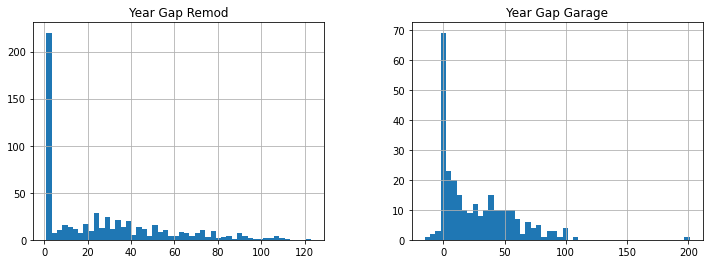

In [ ]:
tmp = train[['Year Gap Remod', 'Year Gap Garage']]
tmp[tmp != 0].hist(bins=50, figsize=(12,4))

In [ ]:
cnt = train.loc[train['Year Gap Garage'] > 0, 'Year Built'].count()
cnt / train.shape[0] # 20%

0.19555555555555557

In [ ]:
train[['Year Gap Remod', 'Year Gap Garage']].describe()

,Year Gap Remod,Year Gap Garage
count,1350.000000,1350.000000
mean,12.111852,5.336296
std,23.181786,16.166923
min,0.000000,-15.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,14.000000,0.000000
max,123.000000,106.000000


- 리모델링 후 완공된 (잘못된) 데이터는 없고, 차고가 만들어진 후 완공된 집은 있다.
- 주택 완공 후에 차고가 만들어진 경우가 20%에 달한다.
- 주택 완공 후 평균 12년 후에 리모델링을 하고, 5년 후에 차고를 만든 것으로 나타난다.

In [ ]:
train[train['Full Bath']== 0]

,Year Built,Year Remod/Add,Garage Yr Blt,Overall Qual,Exter Qual,Kitchen Qual,Bsmt Qual,Gr Liv Area,Total Bsmt SF,1st Flr SF,Garage Area,Garage Cars,Full Bath,target
218,1981,1987,1981,9,4,4,5,1842,1842,1842,894,3,0,385000
314,1949,1950,1958,2,3,3,3,480,480,480,308,1,0,35311
412,1996,1997,1996,6,3,3,5,936,920,936,460,2,0,140000
695,1976,1976,1976,8,4,4,4,1743,966,1743,529,2,0,279000
933,1979,1979,1979,5,3,3,4,1224,1086,1224,528,2,0,153337
1171,1969,1969,1969,4,3,3,4,1258,1198,1258,400,2,0,108959


- 화장실이 없는 집이 6개 있다.


- 지상층 면적 단위 : square feet 
- 지상층과 1층은 어떤 의미?   
데이터에서는 지상층 생활 면적이 1층 면적보다 크다 

지상층(Ground Living Area)는 땅 위에 있는 전체 면적을 이야기하는데 차고와 지하실을 제외한다고 한다.  
Gr Liv Area - 1st Flr SF >0 일 경우에 2층이 있는 것이므로 
2층 면적 피처와 2층의 존재 여부를 새로운 피처로 만들 수 있겠다.

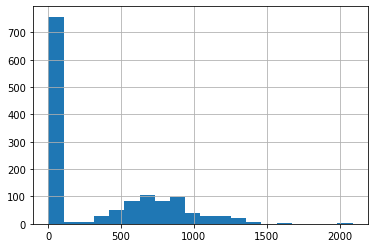

In [ ]:
# 1stFlrSF : 1층 면적
# GrLivArea : 지상층 생활 면적
train['SF Gap'] = train['Gr Liv Area'] - train['1st Flr SF']
# train[['1st Flr SF', 'Gr Liv Area', 'SF Gap']]
train['SF Gap'].hist(bins=20)

- 차고가 없는 집은 없고 'Garage Cars'는 모두 1 이상이다
- 지상층과 1층의 면적이 동일한 집에도 Garage Cars가 1대 이상 있는 걸로 봐서는 지상층과 1층(어느것이 아래에 있는지는 모르겠지만) 그 외에 공간에 차고가 있는 것으로 파악된다. 그래서 외부 차고 존재 여부에 대해서 피처를 만들면 좋을 것 같다.

In [ ]:
# 지상층 면적 단위 
train['Total 1st SF'] = train['1st Flr SF'] + train['Garage Area']
train['Gap SF'] = train['Gr Liv Area'] - train['Total 1st SF']
train.loc[train['SF Gap']!=0,['Gr Liv Area', '1st Flr SF','Total 1st SF', 'Gap SF', 'Garage Area','Garage Cars']]

,Gr Liv Area,1st Flr SF,Total 1st SF,Gap SF,Garage Area,Garage Cars
3,1174,680,1256,-82,576,2
4,1958,1026,1962,-4,936,3
5,1968,774,1454,514,680,3
8,2649,1515,2261,388,746,3
13,1242,647,827,415,180,1
14,1989,1091,1677,312,586,2
17,1200,600,1080,120,480,2
18,2799,1565,2269,530,704,3
22,1651,1035,1311,340,276,1
24,1422,704,1144,278,440,2


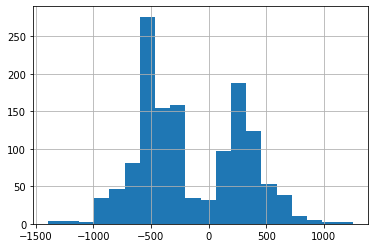

In [ ]:
train['Gap SF'].hist(bins=20)
# 음수일 경우 